# Transfer learning - Survival prediction
Here we are initializing the survival prediction task by using the pre-trained weights from the "foundation model" and fine tuning on survival prediction. We use for training 70% of the data and 30% for validation. 

This notebook guides you through the use of the clinical transformere API

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/shenwanxiang/anaconda3"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
tf.test.is_gpu_available()

tf.config.run_functions_eagerly(True)

tf.__version__
import sys
sys.path.append('../codeocean/environment/clinical_transformer/')



2025-08-12 18:35:09.557480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-12 18:35:09.613290: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-12 18:35:09.960133: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenwanxiang/anaconda3/lib:
2025-08-12 18:35:09.960166: W tensorflow/compiler/xla/stream_exe

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2025-08-12 18:35:10.368521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-12 18:35:10.379964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 18:35:10.396116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 18:35:10.396203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

In [2]:
from xai.models import Trainer
from xai.models import SurvivalTransformer
from xai.models import OptimizedSurvivalDataGenerator as SurvivalDataGenerator
from xai.losses.survival import cIndex_SigmoidApprox as cindex_loss
from xai.metrics.survival import sigmoid_concordance as cindex_metric

In [3]:
import pandas as pd
from samecode.random import set_seed

## Dataset

In [6]:
data = pd.read_csv('./data/dataset-train.data.csv')
features = data.columns[-29:].tolist()
features

['Angiogenesis',
 'Antitumor cytokines',
 'B cells',
 'Cancer-associated fibroblasts',
 'Checkpoint molecules',
 'Co-stimulatory ligands',
 'Co-stimulatory receptors',
 'Effector cell traffic',
 'Effector cells',
 'Endothelium',
 'Granulocyte traffic',
 'Immune Suppression by Myeloid Cells',
 'M1 signature',
 'MHCI',
 'MHCII',
 'Macrophage and DC traffic',
 'Matrix',
 'Matrix remodeling',
 'Myeloid cells traffic',
 'NK cells',
 'Neutrophil signature',
 'Protumor cytokines',
 'T cells',
 'Th1 signature',
 'Th2 signature',
 'Treg',
 'Treg and Th2 traffic',
 'Tumor proliferation rate',
 'Tumor-associated Macrophages']

## Parameters

In [7]:
max_features_percentile=100
test_size=0.3 # fraction of samples used for validation
repetitions=1 # number replicates (training / validation) random splits to evaluate variability.

mode='survival'
learning_rate=0.0001
epochs=100
verbose=1
seed=0
embedding_size = 128
num_heads = 2
num_layers = 2

## Training

In [8]:
!rm -r ./results/runs/TransferLearningSurvival/

/bin/sh: /home/shenwanxiang/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/sh)
rm: cannot remove './results/runs/TransferLearningSurvival/': No such file or directory


In [9]:
outdir = './results/runs/TransferLearningSurvival/'
set_seed(0)

trainer = Trainer(
    from_pretrained='./results/runs/FoundationModel/fold-0_id-0/model.E001000.h5',
    out_dir = outdir,
    max_features_percentile=max_features_percentile,
    test_size=test_size,
    mode=mode,
    model=SurvivalTransformer, 
    dataloader=SurvivalDataGenerator,
    loss=cindex_loss,
    metrics=[cindex_metric]
)

trainer.setup_data(
    data, 
    discrete_features = [],
    continuous_features = features,
    target=['time', 'event']
)

trainer.setup_model(
    learning_rate=learning_rate,
    embedding_size=embedding_size,
    num_heads=num_heads,
    num_layers=num_layers,
    batch_size_max=True,
    save_best_only=False
)

trainer.fit(repetitions=repetitions, epochs=epochs, verbose=verbose, seed=seed)

/home/shenwanxiang/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO	2025-08-12 18:35:51,800	Setting up working directory: ./results/runs/TransferLearningSurvival/
INFO	2025-08-12 18:35:51,801	Setting up transfer learning directory: ./results/runs/TransferLearningSurvival//model.E001000.h5/
2025-08-12 18:35:51.804250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 18:35:51.804397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-08-12 18:35:51.804457: I tensorflow/compil

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-12 18:35:52,709	AutoGraph could not transform <function cIndex_SigmoidApprox at 0x7f985e9e7050> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


WARNING	2025-08-12 18:35:52,808	AutoGraph could not transform <function sigmoid_concordance at 0x7f985dd964d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 252ms/step - loss: 0.5127 - sigmoid_concordance: 0.4669 - val_loss: 0.4762 - val_sigmoid_concordance: 0.6160
Epoch 2/100
1/1 [==============================] - 0s 150ms/step - loss: 0.4978 - sigmoid_concordance: 0.5074 - val_loss: 0.4710 - val_sigmoid_concordance: 0.6159
Epoch 3/100
1/1 [==============================] - 0s 119ms/step - loss: 0.4937 - sigmoid_concordance: 0.5115 - val_loss: 0.4662 - val_sigmoid_concordance: 0.6075
Epoch 4/100
1/1 [==============================] - 0s 119ms/step - loss: 0.4858 - sigmoid_concordance: 0.5315 - val_loss: 0.4616 - val_sigmoid_concordance: 0.5991
Epoch 5/100
1/1 [==============================] - 0s 120

Text(0, 0.5, 'Cindex loss')

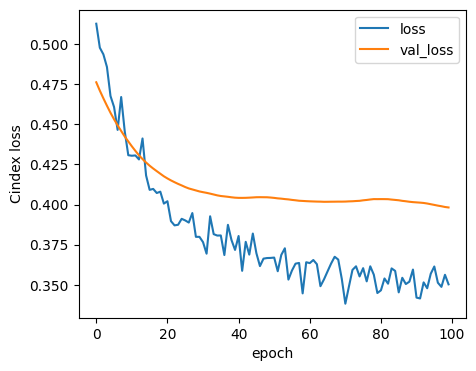

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

dfh = pd.read_csv("./results/runs/TransferLearningSurvival/model.E001000.h5/fold-0_id-0/history.csv", index_col=0)
fig, ax=plt.subplots(figsize=(5,4))
dfh[['loss', 'val_loss']].plot(ax=ax)
ax.set_ylabel('Cindex loss')